In [34]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [35]:
import numpy as np
import pandas as pd

In [36]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [37]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, Integer, String, Float
Base = declarative_base()

In [38]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo = False)
inspector = inspect(engine)

In [39]:
inspector.get_table_names()

['measurement', 'station', 'stations']

In [40]:
columns = inspector.get_columns('measurement')
# columns = inspector.get_columns('station')
# columns = inspector.get_columns('stations')

In [41]:
columns = inspector.get_columns('measurement')
# columns = inspector.get_columns('station')
# columns = inspector.get_columns('stations')
for column in columns:
    print(column['name'],column['type'],column['nullable'],['primary_key'])
#     print(column)

id INTEGER False ['primary_key']
station TEXT True ['primary_key']
date TEXT True ['primary_key']
prcp FLOAT True ['primary_key']
tobs FLOAT True ['primary_key']


In [42]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [43]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine,reflect=True)

In [44]:
Base.classes.keys()

['measurement', 'station', 'stations']

In [45]:
# We can view all of the classes that automap found   --  this has been done with inspector.get tables above
Base.metadata.tables

immutabledict({'measurement': Table('measurement', MetaData(bind=None), Column('id', INTEGER(), table=<measurement>, primary_key=True, nullable=False), Column('station', TEXT(), table=<measurement>), Column('date', TEXT(), table=<measurement>), Column('prcp', FLOAT(), table=<measurement>), Column('tobs', FLOAT(), table=<measurement>), schema=None), 'station': Table('station', MetaData(bind=None), Column('id', INTEGER(), table=<station>, primary_key=True, nullable=False), Column('station', TEXT(), table=<station>), Column('name', TEXT(), table=<station>), Column('latitude', FLOAT(), table=<station>), Column('longitude', FLOAT(), table=<station>), Column('elevation', FLOAT(), table=<station>), schema=None), 'stations': Table('stations', MetaData(bind=None), Column('station', VARCHAR(), table=<stations>, primary_key=True, nullable=False), Column('date', VARCHAR(), table=<stations>), Column('prcp', INTEGER(), table=<stations>), Column('tobs', INTEGER(), table=<stations>), schema=None)})

In [46]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station
Stations = Base.classes.stations

In [47]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [48]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fe6a25b5438>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'id': 1,
 'tobs': 65.0,
 'date': '2010-01-01'}

# Exploratory Climate Analysis

In [49]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print (f"The last date in the data: {last_date[0]}")

# Calculate the date 1 year ago from the last data point in the database
one_year_ago = (dt.datetime.strptime(last_date[0],'%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')
print("One year ago Query date: ", one_year_ago)

The last date in the data: 2017-08-23
One year ago Query date:  2016-08-23


In [50]:
# Perform a query to retrieve the date and precipitation scores for the last year of data
rain_scores = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>=one_year_ago).all()
rain_scores
rain_scores[:5]

[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0)]

In [51]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df =pd.DataFrame(rain_scores,columns=['Date','Precipitation'])
df.head()


,Date,Precipitation
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


In [52]:
# Sort the dataframe by date
df.set_index(df['Date'],inplace=True)
df=df.sort_index()
# df.head()

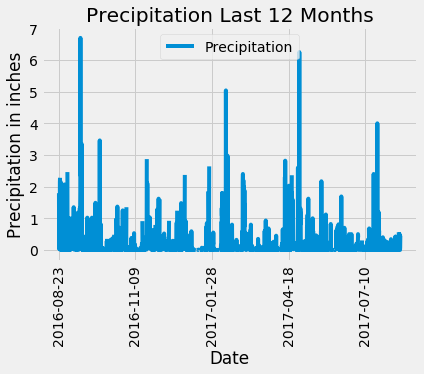

In [53]:
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(rot=90)
plt.xlabel('Date')
plt.ylabel('Precipitation in inches');
plt.title("Precipitation Last 12 Months");
plt.savefig('Images/twelve_month_precipitation.png')

In [54]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [55]:
# Design a query to show how many stations are available in this dataset?
station_count =session.query(func.count(Station.station)).all()
station_count[0]

(9)

In [56]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

active_stations = session.query(Station.station, func.count(Measurement.station).label('actives')).\
                  filter(Station.station == Measurement.station).\
                  group_by(Station.station).\
                  order_by(func.count(Measurement.station).desc()).\
                  all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [57]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()
print (f" These are the stats for most active Station id = USC00519281")
print(f" Low  : {temperature_stats[0][0]}")
print(f" High : {temperature_stats[0][1]}")
print(f" Avg  : {temperature_stats[0][2]}")

 These are the stats for most active Station id = USC00519281
 Low  : 54.0
 High : 85.0
 Avg  : 71.66378066378067


In [58]:
# Choose the station with the highest number of temperature observations.

temperature = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').filter(Measurement.date >= one_year_ago).\
    group_by(Measurement.date).all()
        
temperature_observation_df = pd.DataFrame(temperature,columns = ['Date','TOBS'])
# temperature_observation_df.head()

temperature_observation_df.set_index(temperature_observation_df['Date'],inplace = True)
temperature_observation_df.sort_index()

,Date,TOBS
Date,,
2016-08-23,2016-08-23,77.0
2016-08-24,2016-08-24,77.0
2016-08-25,2016-08-25,80.0
2016-08-26,2016-08-26,80.0
2016-08-27,2016-08-27,75.0
...,...,...
2017-08-14,2017-08-14,77.0
2017-08-15,2017-08-15,77.0
2017-08-16,2017-08-16,76.0


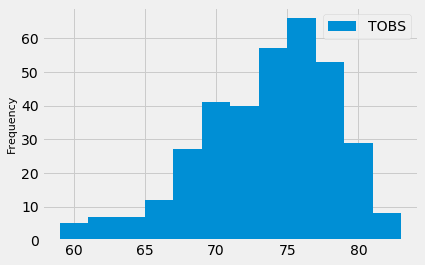

In [59]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
plt.hist(temperature_observation_df['TOBS'],12, label="TOBS")
plt.ylabel("Frequency", fontsize=11)
plt.legend()
plt.savefig('Images/twelve_month_temp.png')
plt.show()

In [60]:
 # This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [61]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
#trip dates: 2018-03-01 to 2018-03-10
trip_data = calc_temps('2017-05-01', '2017-05-10')
trip_data

[(65.0, 75.12280701754386, 80.0)]

In [62]:
tmin = trip_data[0][0]
tavg = trip_data[0][1]
tmax = trip_data[0][2]

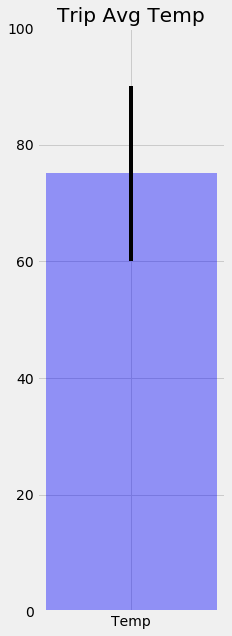

In [63]:
 # Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(3,10))
plt.bar(x='Temp',height=tavg, yerr=(tmax-tmin), color='b', alpha=0.4)
plt.ylim([0,100])
plt.title('Trip Avg Temp')
plt.savefig('Images/trip_avg_temp.png')
plt.show()

In [64]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

In [65]:
 # Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [66]:
 # calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date

In [67]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

In [68]:
 # Plot the daily normals as an area plot with `stacked=False`